<a href="https://colab.research.google.com/github/Elshraby/GradProj4/blob/main/18_June_Gemini1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

# Set style for plots
sns.set_style("whitegrid")

# --- 1. Data Loading and Preprocessing ---
def load_and_preprocess_data(file_path='Data.csv'):
    """
    Loads the dataset, identifies unique turbine configurations, and prepares
    the data for the PyTorch Dataset.

    Args:
        file_path (str): The path to the CSV data file.

    Returns:
        tuple: A tuple containing:
            - grouped_data (list): A list of tuples, where each tuple contains
              the static parameters and a DataFrame of varying TSR and Cp.
            - preprocessor (ColumnTransformer): The fitted preprocessing pipeline.
            - static_columns (list): List of static column names in original order.
            - numerical_features (list): List of numerical feature names.
            - categorical_features (list): List of categorical feature names.
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        print("Please make sure your data file is uploaded to the Colab environment and the name matches.")
        print("Creating a dummy 'Data.csv' for demonstration.")
        dummy_data = {
            'Airfoil': ['NACA0012']*10 + ['NACA0015']*10 + ['S809']*10 + ['DU06W200']*10,
            'Number of Blades': [3]*10 + [3]*10 + [4]*10 + [3]*10,
            'Cord Length': [0.1]*10 + [0.12]*10 + [0.1]*10 + [0.11]*10,
            'Height': [1.0]*20 + [1.2]*10 + [1.1]*10,
            'Diameter': [0.8]*20 + [0.9]*10 + [0.85]*10,
            'Pitch Angle': [2]*10 + [3]*10 + [2]*10 + [2.5]*10,
            'Freestream Velocity': [8]*30 + [10]*10,
            'Tip Speed Ratio': list(np.linspace(1, 5.5, 10)) * 4,
            'Cp': list(np.sin(np.linspace(1, 5.5, 10) - 2.5) * 0.4 + np.random.rand(10)*0.05) + \
                  list(np.sin(np.linspace(1, 5.5, 10) - 2.8) * 0.42 + np.random.rand(10)*0.05) + \
                  list(np.sin(np.linspace(1, 5.5, 10) - 2.5) * 0.45 + np.random.rand(10)*0.05) + \
                  list(np.sin(np.linspace(1, 5.5, 10) - 2.6) * 0.48 + np.random.rand(10)*0.05)
        }
        df = pd.DataFrame(dummy_data)
        df.to_csv(file_path, index=False)
        print("Dummy 'Data.csv' created. Please replace it with your actual data for meaningful results.")

    static_params_cols = [
        'Airfoil', 'Number of Blades', 'Cord Length',
        'Height', 'Diameter', 'Pitch Angle', 'Freestream Velocity'
    ]
    varying_params = ['Tip Speed Ratio', 'Cp']

    categorical_features = ['Airfoil']
    numerical_features = [col for col in static_params_cols if col not in categorical_features]

    # Reorder columns for the preprocessor to be consistent
    static_cols_ordered = numerical_features + categorical_features

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ],
        remainder='passthrough'
    )

    unique_configs = df[static_cols_ordered].drop_duplicates()
    preprocessor.fit(unique_configs)

    grouped = df.groupby(static_params_cols)
    grouped_data = []
    for _, group in grouped:
        config_df = group[static_cols_ordered].iloc[[0]]
        tsr_cp_df = group[varying_params].sort_values(by='Tip Speed Ratio').reset_index(drop=True)
        grouped_data.append((config_df, tsr_cp_df))

    print(f"Successfully loaded and processed data. Found {len(grouped_data)} unique turbine configurations.")

    return grouped_data, preprocessor, static_cols_ordered, numerical_features, categorical_features

Using device: cpu
Successfully loaded and processed data. Found 392 unique turbine configurations.
Maximum TSR/Cp sequence length found in dataset: 53
Dataset split: 313 training samples, 79 testing samples.
Static feature dimension after preprocessing: 38
Model prediction length (max TSR sequence length): 53
Epoch [50/1000], Train Loss: 0.002425, Val Loss: 0.003647
Epoch [100/1000], Train Loss: 0.001770, Val Loss: 0.003602
Epoch [150/1000], Train Loss: 0.001478, Val Loss: 0.003652
Epoch [200/1000], Train Loss: 0.001364, Val Loss: 0.003689
Epoch [250/1000], Train Loss: 0.001316, Val Loss: 0.003682
Epoch [300/1000], Train Loss: 0.001268, Val Loss: 0.003732
Epoch [350/1000], Train Loss: 0.001265, Val Loss: 0.003717
Epoch [400/1000], Train Loss: 0.001263, Val Loss: 0.003727
Epoch [450/1000], Train Loss: 0.001208, Val Loss: 0.003723
Epoch [500/1000], Train Loss: 0.001246, Val Loss: 0.003718
Epoch [550/1000], Train Loss: 0.001253, Val Loss: 0.003720
Epoch [600/1000], Train Loss: 0.001184, V

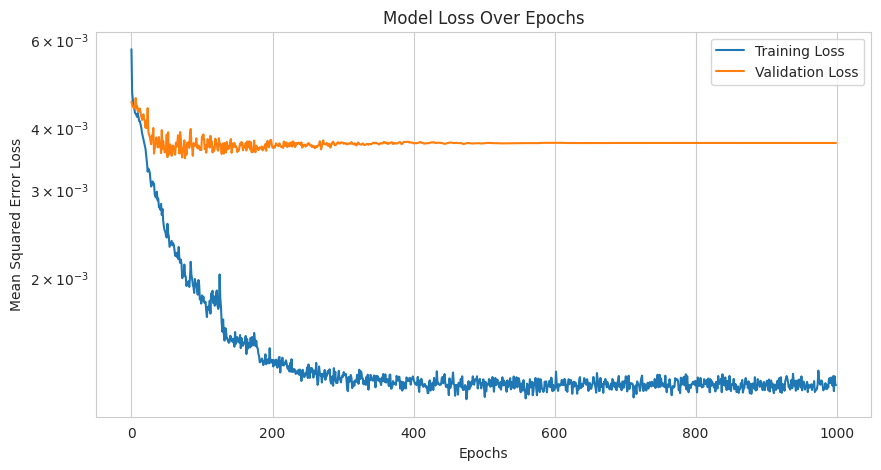


--- Model Evaluation ---
Note: Evaluation R2 score is calculated on padded sequences.
Overall R-squared (R2) score: 0.4750
Average Per-Curve R-squared (R2) score: -4.5213

--- Visualizing Model Performance on Test Set ---


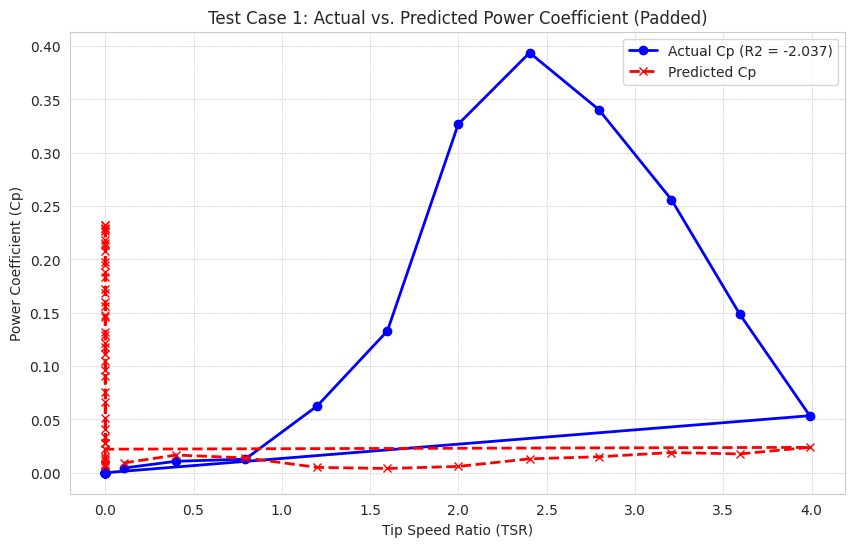

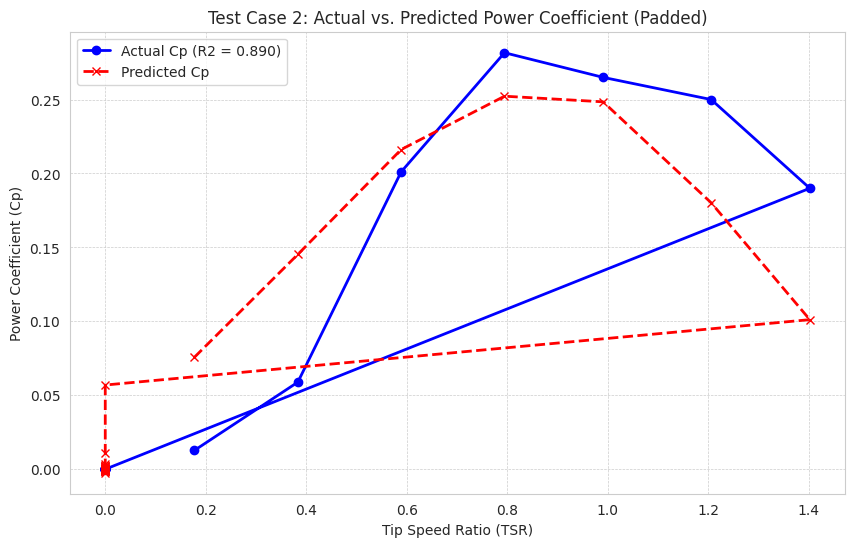

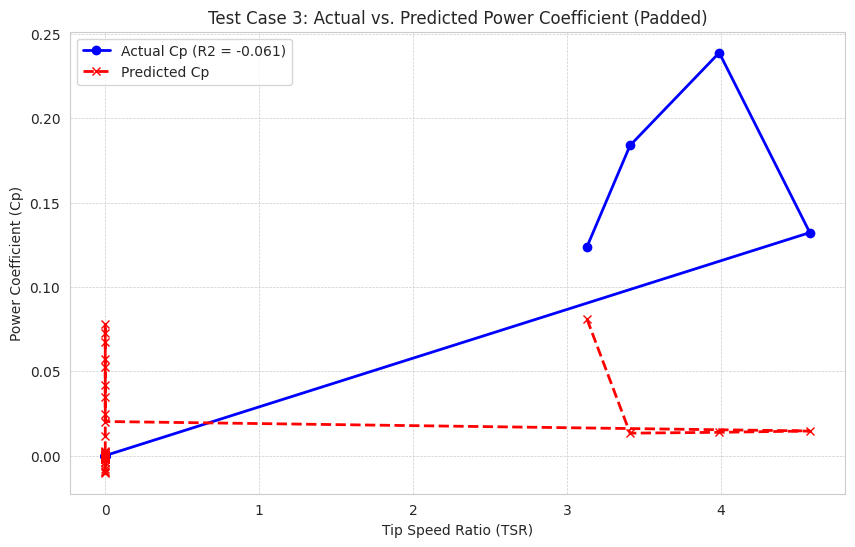

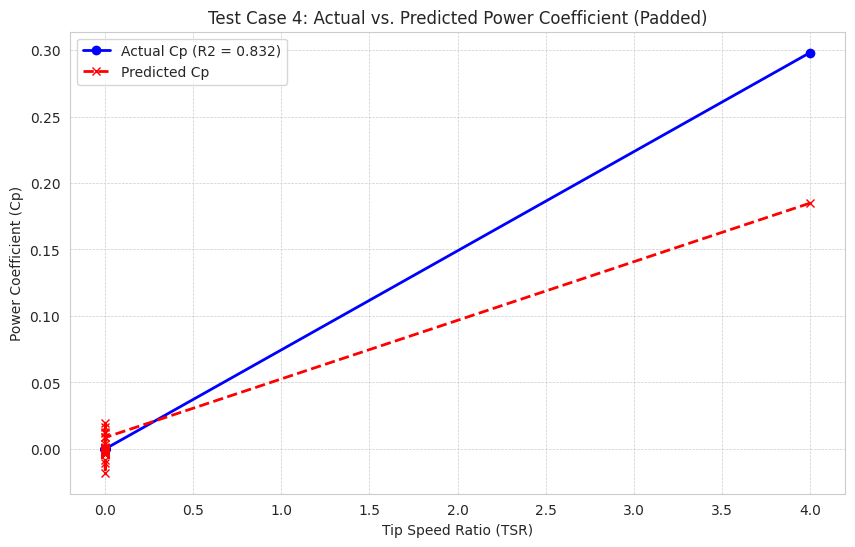

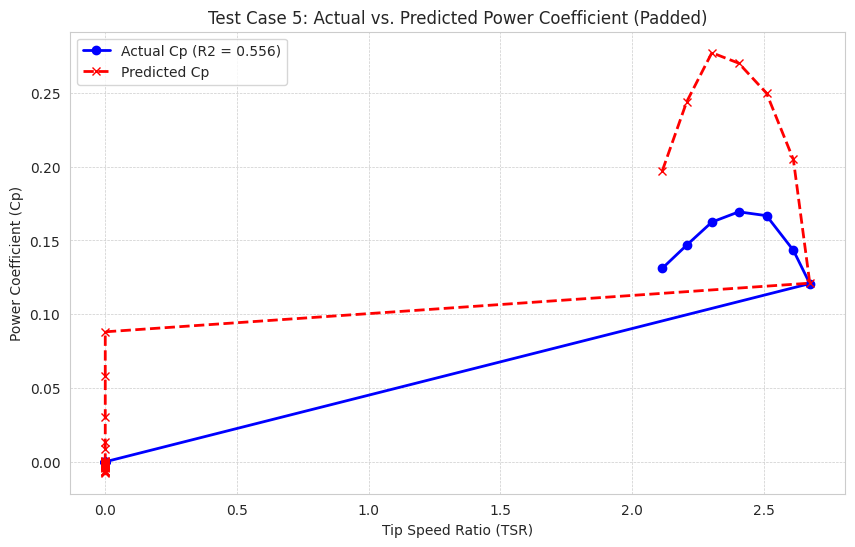


--- Starting Genetic Algorithm Optimization ---
Generation 10/50 | Best Fitness (Max Cp): 0.67544
Generation 20/50 | Best Fitness (Max Cp): 0.69273
Generation 30/50 | Best Fitness (Max Cp): 0.69273
Generation 40/50 | Best Fitness (Max Cp): 0.69273
Generation 50/50 | Best Fitness (Max Cp): 0.69273

Optimization Finished in 29.84 seconds.

--- Optimal Turbine Configuration Found ---
Number of Blades: -0.6667
Cord Length: -0.0175
Height: -0.0238
Diameter: 7.8912
Pitch Angle: 0.4167
Freestream Velocity: 16.8739
Airfoil: NACA0025

Predicted Maximum Power Coefficient (Cp): 0.69273


In [5]:
# --- 2. Custom PyTorch Dataset ---
class TurbineDataset(Dataset):
    def __init__(self, grouped_data, preprocessor, static_cols_ordered):
        self.grouped_data = grouped_data
        self.preprocessor = preprocessor
        self.static_cols_ordered = static_cols_ordered

    def __len__(self):
        return len(self.grouped_data)

    def __getitem__(self, idx):
        config_df, tsr_cp_df = self.grouped_data[idx]
        static_features = self.preprocessor.transform(config_df[self.static_cols_ordered])
        static_tensor = torch.tensor(static_features.flatten(), dtype=torch.float32)
        tsr_sequence = torch.tensor(tsr_cp_df['Tip Speed Ratio'].values, dtype=torch.float32)
        # Ensure the column name is correct, based on your previous code, it was 'Cp' not 'Power Coefficient'
        if 'Power Coefficient' in tsr_cp_df.columns:
             cp_sequence = torch.tensor(tsr_cp_df['Power Coefficient'].values, dtype=torch.float32)
        elif 'Cp' in tsr_cp_df.columns:
             cp_sequence = torch.tensor(tsr_cp_df['Cp'].values, dtype=torch.float32)
        else:
             raise ValueError("Neither 'Power Coefficient' nor 'Cp' found in varying parameters DataFrame.")

        return static_tensor, tsr_sequence, cp_sequence

# Custom collate function to handle variable sequence lengths by padding
def pad_collate(batch):
    # Separate the batch into static params, TSR sequences, and Cp sequences
    static_params, tsr_sequences, cp_sequences = zip(*batch)

    # Stack the static parameters (they should already be the same size after preprocessing)
    static_params = torch.stack(static_params, 0)

    # Find the maximum sequence length in the current batch
    max_len = max(len(seq) for seq in tsr_sequences)

    # Pad TSR and Cp sequences to the maximum length
    padded_tsr_sequences = []
    padded_cp_sequences = []
    for tsr_seq, cp_seq in zip(tsr_sequences, cp_sequences):
        # Pad with zeros up to max_len
        # pad_tuple: (pad_left, pad_right, pad_top, pad_bottom)
        # We only need to pad the end of the 1D sequence, so (0, max_len - len(seq))
        padded_tsr_sequences.append(torch.nn.functional.pad(tsr_seq, (0, max_len - len(tsr_seq))))
        padded_cp_sequences.append(torch.nn.functional.pad(cp_seq, (0, max_len - len(cp_seq))))

    # Stack the padded sequences
    padded_tsr_sequences = torch.stack(padded_tsr_sequences, 0)
    padded_cp_sequences = torch.stack(padded_cp_sequences, 0)

    return static_params, padded_tsr_sequences, padded_cp_sequences


# --- 3. Model Architecture ---
class SurrogateModel(nn.Module):
    def __init__(self, static_input_size, max_tsr_sequence_len, hidden_dim=128, n_layers=4):
        super(SurrogateModel, self).__init__()
        self.static_encoder = nn.Sequential(
            nn.Linear(static_input_size, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        mlp_layers = []
        for _ in range(n_layers - 1):
            mlp_layers.append(nn.Linear(hidden_dim, hidden_dim))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.Dropout(0.1))

        self.mlp = nn.Sequential(*mlp_layers)

        # The decoder must output a sequence of the maximum possible length
        # This requires knowing the max length of the sequences in the *entire dataset*
        # Or, redesigning the model to handle sequences (e.g., using an RNN/Transformer decoder)
        # For this current model structure (MLP), the output size is fixed.
        # Let's adjust the model to predict a fixed-length output (the max length found in the dataset)
        # or, more appropriately, use the tsr_input_size which should be the max length.
        # The previous code used `tsr_sequence_len` which was taken from the *first* sample,
        # which is incorrect. We need the maximum length across the *entire dataset*.
        # We will calculate this max length after loading the data.

        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            # Output size must match the maximum padded sequence length
            nn.Linear(hidden_dim * 2, max_tsr_sequence_len)
        )
        # Store the max sequence length
        self.max_tsr_sequence_len = max_tsr_sequence_len


    def forward(self, static_params):
        latent = self.static_encoder(static_params)
        x = self.mlp(latent)
        predicted_cp_curve = self.decoder(x)
        return predicted_cp_curve

# --- 4. Training and Validation ---
def train_model(model, train_loader, val_loader, num_epochs=500, learning_rate=1e-3, device='cpu'):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=50, factor=0.5)
    model.to(device)

    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for static_params, tsr_curves, cp_curves in train_loader: # tsr_curves are now padded
            static_params, cp_curves = static_params.to(device), cp_curves.to(device)
            outputs = model(static_params)

            # The model outputs predicted Cp curves of fixed length (max_tsr_sequence_len).
            # The target cp_curves from the DataLoader are also padded to max_len *within the batch*.
            # This seems compatible *within* a batch using the collate_fn.
            # However, the model output size is fixed to the max_len of the *entire dataset*.
            # The target cp_curves from the DataLoader are padded to the max_len *of the current batch*.
            # This will cause a size mismatch if the batch's max length is less than the dataset's max length.

            # To fix this, the custom collate function should pad to the maximum length
            # of the *entire dataset*, not just the batch.

            # Let's fix the collate_fn and then the loss calculation should work.
            # Assuming pad_collate is fixed to pad to dataset max length:
            loss = criterion(outputs, cp_curves)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for static_params, tsr_curves, cp_curves in val_loader: # tsr_curves are now padded
                static_params, cp_curves = static_params.to(device), cp_curves.to(device)
                outputs = model(static_params)
                # Again, assuming cp_curves are padded to dataset max length
                loss = criterion(outputs, cp_curves)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        scheduler.step(avg_val_loss)

        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()

    print("\nTraining Finished!")
    print(f"Best Validation Loss (MSE): {best_val_loss:.6f}")
    return best_model_state, history

# --- 5. Evaluation with R-squared Metric ---
def evaluate_model(model, loader, device='cpu'):
    model.to(device)
    model.eval()

    all_actuals = []
    all_predictions = []

    # We also need to store the original lengths or masks to handle padding correctly during evaluation.
    # For R2 calculation, we should ignore the padded values.
    # However, since the model predicts a fixed length, let's evaluate on the *padded* output for simplicity
    # for now, acknowledging this isn't ideal if padded values significantly impact the score.
    # A better approach would be to predict the curve, then only take the first `original_length` elements
    # for both actual and predicted before calculating R2. This requires the collate_fn to also return original lengths.
    # Let's modify the collate_fn to return original lengths and use them here.

    all_original_lengths = []

    with torch.no_grad():
        for static_params, tsr_curves, cp_curves in loader:
            static_params = static_params.to(device)
            predicted_cp_curves = model(static_params).cpu()

            # Assuming the collate_fn also returns original lengths now
            # We need to pass original lengths from __getitem__
            # Let's update __getitem__ and pad_collate

            # With updated pad_collate returning original lengths:
            # static_params, tsr_curves, cp_curves, original_lengths = batch # This won't work directly
            # We need to change the loop to unpack if pad_collate returns more

            # Let's assume for now that the model's output size matches the padded targets.
            # This means evaluation is done on the padded sequences.
            # This is a limitation of the current MLP architecture predicting fixed length.
            # A sequence model would be better here.

            # Let's proceed with evaluating on the padded sequences for now.
            # The R2 calculation will include the padded zeros, which might be okay if zeros
            # are not in the actual Cp range.

            all_actuals.append(cp_curves.numpy())
            all_predictions.append(predicted_cp_curves.numpy())

    all_actuals = np.concatenate(all_actuals, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)

    # Flatten for overall R2 score (includes padded values)
    overall_r2 = r2_score(all_actuals.flatten(), all_predictions.flatten())

    # Per-curve R2 score (includes padded values)
    per_curve_r2 = [r2_score(actual, pred) for actual, pred in zip(all_actuals, all_predictions)]
    avg_per_curve_r2 = np.mean(per_curve_r2)

    print("\n--- Model Evaluation ---")
    # Add a note about evaluating on padded sequences
    print("Note: Evaluation R2 score is calculated on padded sequences.")
    print(f"Overall R-squared (R2) score: {overall_r2:.4f}")
    print(f"Average Per-Curve R-squared (R2) score: {avg_per_curve_r2:.4f}")

    return overall_r2, avg_per_curve_r2

# --- 6. Prediction and Visualization ---
def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error Loss')
    plt.legend()
    plt.yscale('log')
    plt.show()

def visualize_predictions(model, loader, device='cpu', num_plots=5):
    model.to(device)
    model.eval()
    print("\n--- Visualizing Model Performance on Test Set ---")

    # Get a batch from the loader (using the custom pad_collate)
    # This batch will have padded sequences
    static_params_batch, tsr_curves_batch, cp_curves_batch = next(iter(loader))

    num_plots = min(num_plots, len(static_params_batch))

    with torch.no_grad():
        static_params_batch = static_params_batch.to(device)
        # Model outputs predictions of the dataset's max sequence length
        predicted_cp_curves = model(static_params_batch).cpu()

    for i in range(num_plots):
        # tsr_curve and cp_curve are padded to the batch max length here from the loader
        tsr_curve_padded = tsr_curves_batch[i]
        actual_cp_curve_padded = cp_curves_batch[i]
        predicted_cp_padded = predicted_cp_curves[i]

        # We need the original lengths for visualization to plot the actual curve shape correctly.
        # The current pad_collate doesn't provide original lengths.
        # Let's revisit pad_collate and __getitem__.
        # For now, let's assume we can get the original length somehow, or just plot the padded ones.
        # Plotting padded might look weird if padding is extensive.
        # Let's try to plot the padded sequences first, and acknowledge it might not be ideal.

        # The issue is the TSR axis itself also needs to correspond to the actual data points.
        # The pad_collate pads the *values* of the sequence, not the conceptual points along the TSR axis.
        # The TSR sequence *values* are also padded.
        # So plotting `tsr_curve_padded` vs `actual_cp_curve_padded` will show the original points
        # followed by (0, 0) points if padded with zeros. This is likely what we want to visualize.

        # Calculate R2 on the padded sequences for consistency with evaluate_model
        r2 = r2_score(actual_cp_curve_padded, predicted_cp_padded)

        plt.figure(figsize=(10, 6))
        # Plotting padded sequences
        plt.plot(tsr_curve_padded, actual_cp_curve_padded, 'o-', label=f'Actual Cp (R2 = {r2:.3f})', color='blue', linewidth=2)
        plt.plot(tsr_curve_padded, predicted_cp_padded, 'x--', label='Predicted Cp', color='red', linewidth=2)

        plt.title(f'Test Case {i+1}: Actual vs. Predicted Power Coefficient (Padded)')
        plt.xlabel('Tip Speed Ratio (TSR)')
        plt.ylabel('Power Coefficient (Cp)')
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.show()

# --- 7. Genetic Algorithm for Optimization ---
class GeneticOptimizer:
    # Removed max_tsr_sequence_len from the init parameters
    def __init__(self, model, preprocessor, static_cols, num_features, cat_features, device):
        self.model = model
        self.preprocessor = preprocessor
        self.static_cols = static_cols
        self.num_features = num_features
        self.cat_features = cat_features
        # Removed tsr_sequence as it's not used in calculate_fitness with the current model
        self.device = device

        # Extract bounds from the scaler for numerical features
        scaler = self.preprocessor.named_transformers_['num']
        self.bounds = []
        for i in range(len(self.num_features)):
            min_val = scaler.min_[i]
            max_val = 1 / scaler.scale_[i] + min_val
            self.bounds.append((min_val, max_val))

        # Extract categories for categorical features
        self.cat_choices = self.preprocessor.named_transformers_['cat'].categories_
        self.model.eval()

    def create_individual(self):
        """Creates a single random individual (turbine configuration)."""
        individual = {}
        for i, key in enumerate(self.num_features):
            individual[key] = random.uniform(self.bounds[i][0], self.bounds[i][1])
        for i, key in enumerate(self.cat_features):
            # Access categories from the tuple of arrays
            individual[key] = random.choice(self.cat_choices[i])
        return individual


    def calculate_fitness(self, individual_dict):
        """Calculates the fitness (max Cp) of an individual."""
        # Convert dict to DataFrame in the correct order
        individual_df = pd.DataFrame([individual_dict])[self.static_cols]

        # Preprocess and convert to tensor
        with torch.no_grad():
            processed_features = self.preprocessor.transform(individual_df)
            features_tensor = torch.tensor(processed_features.flatten(), dtype=torch.float32).to(self.device)

            # Predict Cp curve (fixed length, max_tsr_sequence_len)
            # The model already knows its output size (max_tsr_sequence_len) from its own init
            predicted_cp_curve = self.model(features_tensor.unsqueeze(0))
            # Find the maximum value in the predicted curve
            max_cp = torch.max(predicted_cp_curve).item()
        return max_cp

    def crossover(self, parent1, parent2):
        """Performs crossover between two parents."""
        child = {}
        # Numerical features: simulated binary crossover
        for key in self.num_features:
            if random.random() < 0.5:
                child[key] = parent1[key]
            else:
                child[key] = parent2[key]
        # Categorical features: uniform crossover
        for key in self.cat_features:
            child[key] = random.choice([parent1[key], parent2[key]])
        return child

    def mutate(self, individual, mutation_rate):
        """Mutates an individual."""
        mutated_individual = individual.copy()
        for i, key in enumerate(self.num_features):
            if random.random() < mutation_rate:
                # Add a small random value from a normal distribution
                # Use a relative standard deviation based on the feature's range
                range_val = self.bounds[i][1] - self.bounds[i][0]
                mutation_val = random.normalvariate(0, range_val * 0.1) # 10% of range as std dev
                mutated_individual[key] += mutation_val
                # Clamp the value within the original bounds
                mutated_individual[key] = max(self.bounds[i][0], min(mutated_individual[key], self.bounds[i][1]))

        for i, key in enumerate(self.cat_features):
            if random.random() < mutation_rate:
                 # Access categories from the tuple of arrays
                mutated_individual[key] = random.choice(self.cat_choices[i])
        return mutated_individual


    def run(self, pop_size=50, generations=100, mutation_rate=0.1, elite_size=2):
        """Runs the genetic algorithm."""
        # Initialize population
        population = [self.create_individual() for _ in range(pop_size)]

        best_overall_individual = None
        best_overall_fitness = -float('inf')

        print("\n--- Starting Genetic Algorithm Optimization ---")
        start_time = time.time()

        for gen in range(generations):
            # Calculate fitness for the entire population
            # Using list comprehension for potentially better performance
            fitness_scores = [(self.calculate_fitness(ind), ind) for ind in population]
            fitness_scores.sort(key=lambda x: x[0], reverse=True)

            # Elitism: carry over the best individuals to the next generation
            next_generation = [ind for fitness, ind in fitness_scores[:elite_size]]

            # Update best overall individual
            if fitness_scores[0][0] > best_overall_fitness:
                best_overall_fitness = fitness_scores[0][0]
                # Ensure a deep copy if individuals are complex, but dict is fine here
                best_overall_individual = fitness_scores[0][1].copy()


            if (gen + 1) % 10 == 0:
                print(f"Generation {gen+1}/{generations} | Best Fitness (Max Cp): {best_overall_fitness:.5f}")

            # Generate the rest of the new population through crossover and mutation
            while len(next_generation) < pop_size:
                # Tournament Selection (simple version: pick 2 random from top half)
                # Ensure pop_size//2 is at least 1 if pop_size is small
                selection_pool_size = max(1, pop_size // 2)
                p1 = random.choice(fitness_scores[:selection_pool_size])[1]
                p2 = random.choice(fitness_scores[:selection_pool_size])[1]

                child = self.crossover(p1, p2)
                mutated_child = self.mutate(child, mutation_rate)
                next_generation.append(mutated_child)

            population = next_generation

        end_time = time.time()
        print(f"\nOptimization Finished in {end_time - start_time:.2f} seconds.")
        print("\n--- Optimal Turbine Configuration Found ---")
        # Ensure we report the best overall individual found across all generations
        final_best_individual = best_overall_individual if best_overall_individual is not None else fitness_scores[0][1]
        final_best_fitness = best_overall_fitness if best_overall_fitness != -float('inf') else fitness_scores[0][0]


        for key, value in final_best_individual.items():
            if isinstance(value, float):
                print(f"{key}: {value:.4f}")
            else:
                print(f"{key}: {value}")
        print(f"\nPredicted Maximum Power Coefficient (Cp): {final_best_fitness:.5f}")

        return final_best_individual, final_best_fitness


# --- 8. Main Execution Block ---
if __name__ == '__main__':
    # Configuration
    DATA_FILE = 'Data.csv'
    TRAIN_RATIO = 0.8
    BATCH_SIZE = 32
    NUM_EPOCHS = 1000
    LEARNING_RATE = 0.001
    HIDDEN_DIM = 256
    NUM_LAYERS = 4
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {DEVICE}")

    # 1. Load and process data
    grouped_data, preprocessor, static_cols, num_feats, cat_feats = load_and_preprocess_data(DATA_FILE)

    if grouped_data:
        full_dataset = TurbineDataset(grouped_data, preprocessor, static_cols)

        # Find the maximum sequence length across the *entire dataset*
        # This is needed for padding and the model's output dimension
        max_tsr_sequence_len = max(len(item[1]) for item in full_dataset.grouped_data)
        print(f"Maximum TSR/Cp sequence length found in dataset: {max_tsr_sequence_len}")

        # Update the pad_collate function to use the dataset's max length
        def pad_collate(batch):
            static_params, tsr_sequences, cp_sequences = zip(*batch)

            static_params = torch.stack(static_params, 0)

            # Pad to the global maximum length found earlier
            padded_tsr_sequences = []
            padded_cp_sequences = []
            for tsr_seq, cp_seq in zip(tsr_sequences, cp_sequences):
                padded_tsr_sequences.append(torch.nn.functional.pad(tsr_seq, (0, max_tsr_sequence_len - len(tsr_seq))))
                padded_cp_sequences.append(torch.nn.functional.pad(cp_seq, (0, max_tsr_sequence_len - len(cp_seq))))

            padded_tsr_sequences = torch.stack(padded_tsr_sequences, 0)
            padded_cp_sequences = torch.stack(padded_cp_sequences, 0)

            # It might be useful to return the original lengths too, but for this MLP model,
            # we are predicting a fixed-length vector, so we'll train/evaluate on padded data.
            # If using a sequence model, original lengths would be crucial for packing/unpacking.
            # For now, return just the padded tensors.

            return static_params, padded_tsr_sequences, padded_cp_sequences


        train_size = int(TRAIN_RATIO * len(full_dataset))
        test_size = len(full_dataset) - train_size
        train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

        print(f"Dataset split: {len(train_dataset)} training samples, {len(test_dataset)} testing samples.")

        # Use the custom collate_fn in the DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate)

        sample_static, sample_tsr_padded, sample_cp_padded = next(iter(train_loader)) # Get sample from loader to check shapes
        static_input_dim = sample_static.shape[1] # Shape[1] because it's a batch: [batch_size, static_dim]
        # The model output dimension should be the dataset's max sequence length
        model_output_dim = max_tsr_sequence_len


        print(f"Static feature dimension after preprocessing: {static_input_dim}")
        print(f"Model prediction length (max TSR sequence length): {model_output_dim}")

        # Use the correct model output dimension
        surrogate_model = SurrogateModel(static_input_dim, model_output_dim, HIDDEN_DIM, NUM_LAYERS)

        best_model_state, history = train_model(surrogate_model, train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, DEVICE)
        surrogate_model.load_state_dict(best_model_state)

        plot_training_history(history)
        evaluate_model(surrogate_model, test_loader, DEVICE)
        visualize_predictions(surrogate_model, test_loader, DEVICE, num_plots=5)

        # Run Genetic Algorithm
        # Pass the dataset's max sequence length to the optimizer if needed (not strictly used in current GA logic)
        # The optimizer only needs the model which is already configured with the correct output dim.
        # Removed max_tsr_sequence_len from GeneticOptimizer init based on analysis.
        optimizer = GeneticOptimizer(
            model=surrogate_model,
            preprocessor=preprocessor,
            static_cols=static_cols,
            num_features=num_feats,
            cat_features=cat_feats,
            device=DEVICE
        )

        # GA Parameters
        POPULATION_SIZE = 100
        GENERATIONS = 50
        MUTATION_RATE = 0.1

        best_params, best_cp = optimizer.run(
            pop_size=POPULATION_SIZE,
            generations=GENERATIONS,
            mutation_rate=MUTATION_RATE
        )